#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

#### Data Loader

In [2]:
# Import datasets
df1 = pd.read_excel("LR1865SZ_cycles201214_002_4.xlsx")
print("df1:\n", df1.head())
print(f"Number of rows in df1: {len(df1)}\n")
last_cycle_idx = df1['Cycle_Index'].iloc[-1]

df2 = pd.read_excel("LR1865SZ_cycles201217_001_2.xlsx")
df2['Cycle_Index'] = df2['Cycle_Index'] + last_cycle_idx
print("\ndf2:\n", df2.head())
print(f"Number of rows in df2: {len(df2)}\n")

# Join the datasets
df = pd.concat([df1, df2], ignore_index=True)
print("\nJoined df:\n", df.head())
print(f"Number of rows in joined df: {len(df)}\n")

df1:
    Data_Point Test_Time(s)  Current(A)  Capacity(Ah)  Voltage(V)  Energy(Wh)  \
0           1     00:00:00         0.0           0.0      4.1902         0.0   
1           2     00:00:01         0.0           0.0      4.1902         0.0   
2           3     00:00:02         0.0           0.0      4.1893         0.0   
3           4     00:00:04         0.0           0.0      4.1905         0.0   
4           5     00:00:05         0.0           0.0      4.1902         0.0   

  Temperature(℃)           Date_Time  Cycle_Index  
0              - 2020-12-14 10:16:16            1  
1              - 2020-12-14 10:16:18            1  
2              - 2020-12-14 10:16:19            1  
3              - 2020-12-14 10:16:20            1  
4              - 2020-12-14 10:16:21            1  
Number of rows in df1: 202516


df2:
    Data_Point Test_Time(s)  Current(A)  Capacity(Ah)  Voltage(V)  Energy(Wh)  \
0           1     00:00:00         0.0           0.0      4.1859         0.0   
1  

In [3]:
df.drop(columns=['Data_Point'], inplace=True)

# Descriptive statistics
print("Descriptive statistics:\n", df.describe(include='all'))

# Count null values
print("\nTotal Null values:\n", df.isna().sum())

# Type check of features
print("\nType of features:\n", df.dtypes)

Descriptive statistics:
        Test_Time(s)     Current(A)   Capacity(Ah)     Voltage(V)  \
count        329164  329164.000000  329164.000000  329164.000000   
unique       199752            NaN            NaN            NaN   
top      1-05:59:04            NaN            NaN            NaN   
freq              5            NaN            NaN            NaN   
mean            NaN      -0.027540       0.617299       3.718508   
min             NaN      -7.207000       0.000000       2.999400   
25%             NaN      -4.807000       0.305000       3.488700   
50%             NaN       0.000000       0.527000       3.760900   
75%             NaN       4.807000       0.870000       3.983100   
max             NaN       7.207000       2.271000       4.200800   
std             NaN       4.487984       0.417264       0.302283   

           Energy(Wh) Temperature(℃)                      Date_Time  \
count   329164.000000         329164                         329164   
unique          

> ## Insight
- The dataset contained continuous time-series measurements with no missing values.
- A few outliers were observed in capacity and energy, but were within the expected operating range.
- Charging and discharging phases were clearly separated using the current sign (+ve or -ve).

#### Exploratory Data Analysis

Numerical columns: ['Current(A)', 'Voltage(V)', 'Energy(Wh)', 'Capacity(Ah)', 'Cycle_Index', 'charge_capacity', 'discharge_capacity', 'c_rate']


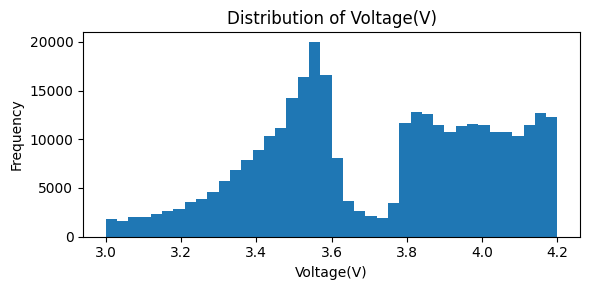

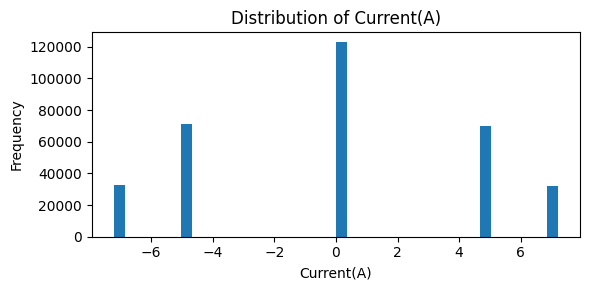

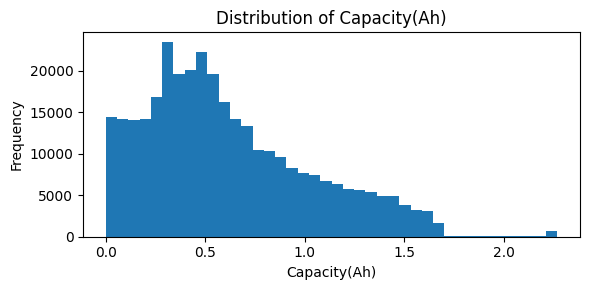

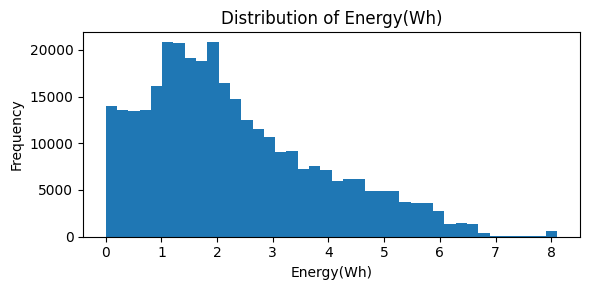

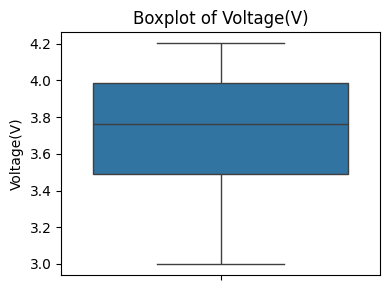

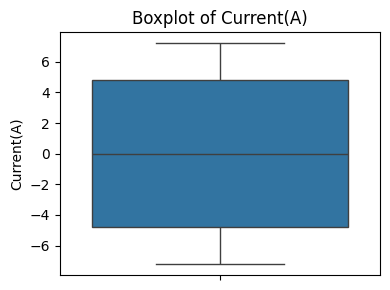

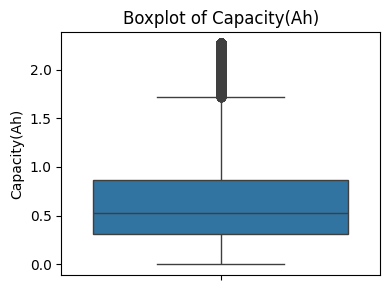

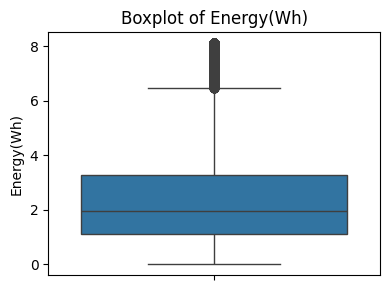

Correlation matrix:                     Current(A)  Voltage(V)  Energy(Wh)  Capacity(Ah)  \
Current(A)            1.000000    0.812291    0.041142     -0.013312   
Voltage(V)            0.812291    1.000000    0.028570     -0.073455   
Energy(Wh)            0.041142    0.028570    1.000000      0.991863   
Capacity(Ah)         -0.013312   -0.073455    0.991863      1.000000   
Cycle_Index           0.007471   -0.046722   -0.408544     -0.405978   
charge_capacity       0.021297    0.047044    0.499725      0.496516   
discharge_capacity   -0.036278    0.020813    0.552510      0.555782   
c_rate                1.000000    0.812291    0.041142     -0.013312   

                    Cycle_Index  charge_capacity  discharge_capacity    c_rate  
Current(A)             0.007471         0.021297           -0.036278  1.000000  
Voltage(V)            -0.046722         0.047044            0.020813  0.812291  
Energy(Wh)            -0.408544         0.499725            0.552510  0.041142  
Capacit

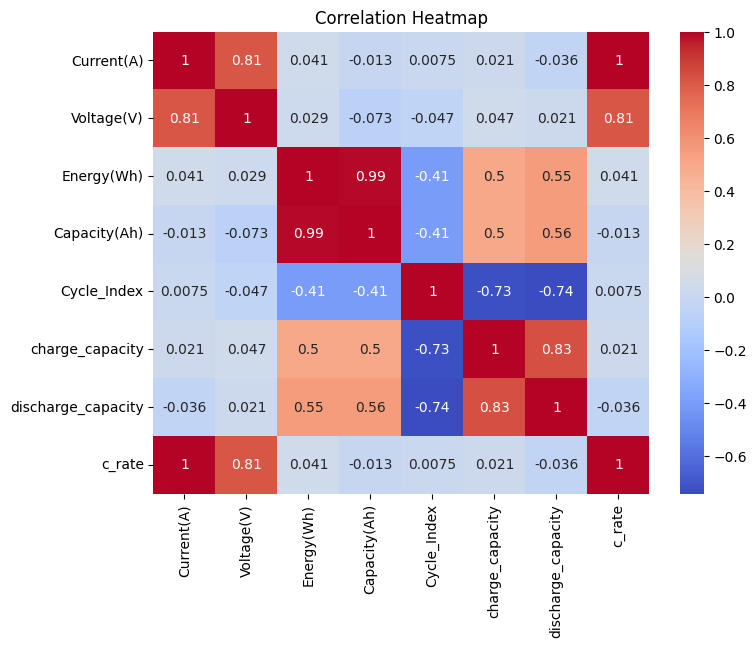

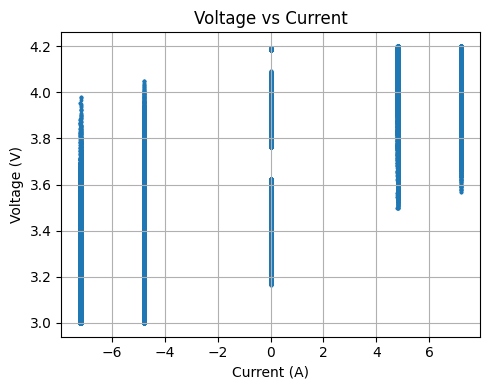

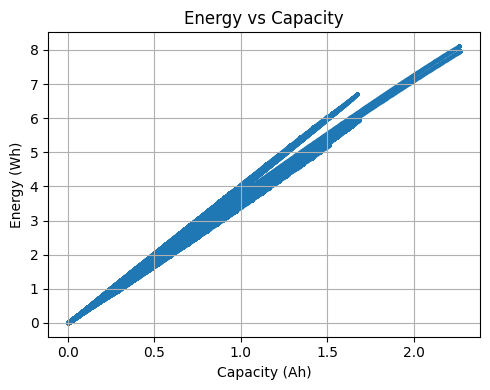

In [52]:
# Univariate EDA 
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)

# Histograms
for c in ['Voltage(V)','Current(A)','Capacity(Ah)','Energy(Wh)']:
    plt.figure(figsize=(6,3))
    plt.hist(df[c], bins=40)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Boxplots to detect outliers
for c in ['Voltage(V)','Current(A)','Capacity(Ah)','Energy(Wh)']:
    plt.figure(figsize=(4,3))
    sns.boxplot(df[c].dropna(), vert=True)
    plt.title(f"Boxplot of {c}")
    plt.tight_layout()
    plt.show()

# Correlation Analysis
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    print("Correlation matrix:", corr)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', annot=True)
    plt.title('Correlation Heatmap')
    # plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    # plt.yticks(range(len(num_cols)), num_cols)
    # plt.tight_layout()
    plt.show()

# Bivariate EDA 

# Voltage vs Current
plt.figure(figsize=(5,4))
plt.scatter(df['Current(A)'], df['Voltage(V)'], s=3)
plt.title('Voltage vs Current')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Capacity vs Energy
plt.figure(figsize=(5,4))
plt.scatter(df['Capacity(Ah)'], df['Energy(Wh)'], s=3)
plt.title('Energy vs Capacity')
plt.xlabel('Capacity (Ah)')
plt.ylabel('Energy (Wh)')
plt.grid(True)
plt.tight_layout()
plt.show()

> ## Insight
- Voltage and Current showed normal distribution, whereas capacity and energy were slightly right skewed in nature, with some outliers.
- Also there is a direct linear correlation among energy and capacity.

#### New Columns

In [5]:
# Create 'phase' column
df['phase'] = df['Current(A)'].apply(lambda x: 'charge' if x >0 else ('discharge' if x < 0 else 'idle'))

# Phase counts
print('\nPhase counts:')
print(df['phase'].value_counts())


Phase counts:
phase
idle         123009
discharge    103835
charge       102320
Name: count, dtype: int64


- New **phase** column was created and most of the cycles were complete, meaning they had both charging and discharging phases.

In [6]:
# Calculate the charge_capacity, discharge_capacity
df["charge_capacity"] = 0.0
df["discharge_capacity"] = 0.0

for i in range(1, len(df)):
    if df.loc[i, "Cycle_Index"] == df.loc[i-1, "Cycle_Index"]:
        dt = (df.loc[i, "Date_Time"] - df.loc[i-1, "Date_Time"]).total_seconds()
        cap_change = (df.loc[i, "Current(A)"] * dt) / 3600
        
        if df.loc[i, "Current(A)"] > 0:   # charging
            df.loc[i, "charge_capacity"] = df.loc[i-1, "charge_capacity"] + cap_change
            df.loc[i, "discharge_capacity"] = df.loc[i-1, "discharge_capacity"]
        else:                             # discharging
            df.loc[i, "discharge_capacity"] = (df.loc[i-1, "discharge_capacity"] - cap_change)
            df.loc[i, "charge_capacity"] = df.loc[i-1, "charge_capacity"]
    else:
        df.loc[i, "charge_capacity"] = 0.0
        df.loc[i, "discharge_capacity"] = 0.0
print("Original df:\n", df.head())

cycle_summary = df.groupby("Cycle_Index").agg({
    "charge_capacity": "max",
    "discharge_capacity": "max"
}).reset_index()
print("\nCycle Summary:\n",cycle_summary.head())

final_df = pd.merge(
    df[['Current(A)', 'Voltage(V)', 'Energy(Wh)', 'Capacity(Ah)', 'Cycle_Index', 'phase']],
    cycle_summary,
    on='Cycle_Index',
    how='left'
)

print("\nFinal df:\n",final_df.head())

Original df:
   Test_Time(s)  Current(A)  Capacity(Ah)  Voltage(V)  Energy(Wh)  \
0     00:00:00         0.0           0.0      4.1902         0.0   
1     00:00:01         0.0           0.0      4.1902         0.0   
2     00:00:02         0.0           0.0      4.1893         0.0   
3     00:00:04         0.0           0.0      4.1905         0.0   
4     00:00:05         0.0           0.0      4.1902         0.0   

  Temperature(℃)           Date_Time  Cycle_Index phase  charge_capacity  \
0              - 2020-12-14 10:16:16            1  idle              0.0   
1              - 2020-12-14 10:16:18            1  idle              0.0   
2              - 2020-12-14 10:16:19            1  idle              0.0   
3              - 2020-12-14 10:16:20            1  idle              0.0   
4              - 2020-12-14 10:16:21            1  idle              0.0   

   discharge_capacity  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  


In [7]:
# New column: 'c-rate'
cell_capacity = 2.3
final_df['c_rate'] = final_df['Current(A)'] / cell_capacity
final_df.head()

,Current(A),Voltage(V),Energy(Wh),Capacity(Ah),Cycle_Index,phase,charge_capacity,discharge_capacity,c_rate
0,0.0,4.1902,0.0,0.0,1,idle,0.0,2.26452,0.0
1,0.0,4.1902,0.0,0.0,1,idle,0.0,2.26452,0.0
2,0.0,4.1893,0.0,0.0,1,idle,0.0,2.26452,0.0
3,0.0,4.1905,0.0,0.0,1,idle,0.0,2.26452,0.0
4,0.0,4.1902,0.0,0.0,1,idle,0.0,2.26452,0.0


Correlation matrix:                     Current(A)  Voltage(V)  Energy(Wh)  Capacity(Ah)  \
Current(A)            1.000000    0.812291    0.041142     -0.013312   
Voltage(V)            0.812291    1.000000    0.028570     -0.073455   
Energy(Wh)            0.041142    0.028570    1.000000      0.991863   
Capacity(Ah)         -0.013312   -0.073455    0.991863      1.000000   
Cycle_Index           0.007471   -0.046722   -0.408544     -0.405978   
charge_capacity       0.021297    0.047044    0.499725      0.496516   
discharge_capacity   -0.036278    0.020813    0.552510      0.555782   
c_rate                1.000000    0.812291    0.041142     -0.013312   

                    Cycle_Index  charge_capacity  discharge_capacity    c_rate  
Current(A)             0.007471         0.021297           -0.036278  1.000000  
Voltage(V)            -0.046722         0.047044            0.020813  0.812291  
Energy(Wh)            -0.408544         0.499725            0.552510  0.041142  
Capacit

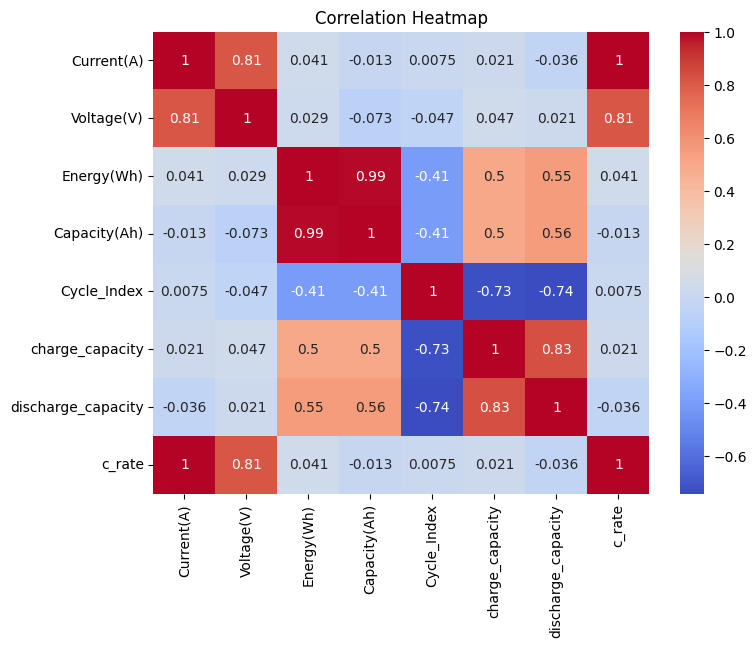

In [19]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = final_df[num_cols].corr()
print("Correlation matrix:", corr)
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

> ## Insight
- Charge capacity and discharge capacity are highly correlated to each other, whereas negatively correlated to Cycle_Index meaning if one increases, the otherr decreases. 

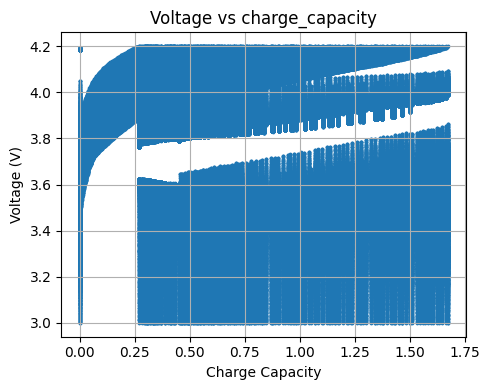

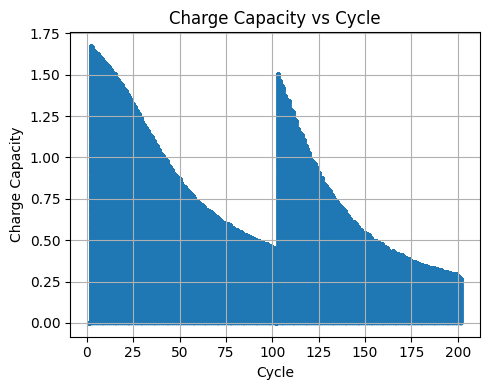

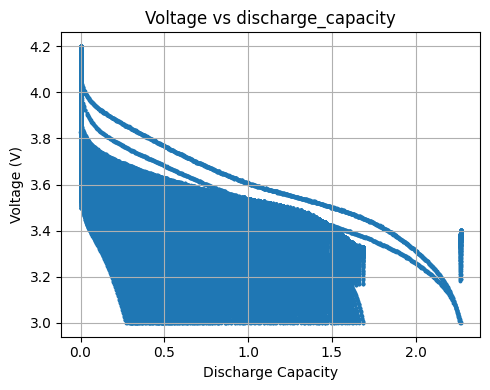

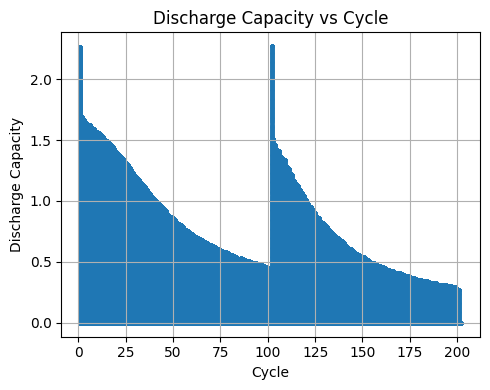

In [9]:
# Voltage vs Charge_capacity
plt.figure(figsize=(5,4))
plt.scatter(df['charge_capacity'], df['Voltage(V)'], s=3)
plt.title('Voltage vs charge_capacity')
plt.xlabel('Charge Capacity')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Charge Capacity vs Cycle 
plt.figure(figsize=(5,4))
plt.scatter(df['Cycle_Index'], df['charge_capacity'], s=3)
plt.title('Charge Capacity vs Cycle')
plt.ylabel('Charge Capacity')
plt.xlabel('Cycle')
plt.grid(True)
plt.tight_layout()
plt.show()


# Voltage vs Discharge_capacity
plt.figure(figsize=(5,4))
plt.scatter(df['discharge_capacity'], df['Voltage(V)'], s=3)
plt.title('Voltage vs discharge_capacity')
plt.xlabel('Discharge Capacity')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Discharge Capacity vs Cycle 
plt.figure(figsize=(5,4))
plt.scatter(df['Cycle_Index'], df['discharge_capacity'], s=3)
plt.title('Discharge Capacity vs Cycle')
plt.ylabel('Discharge Capacity')
plt.xlabel('Cycle')
plt.grid(True)
plt.tight_layout()
plt.show()

> ## Insight
- It can be interpreted from the graphs that charge and discharge capacities decrease as the count of cycle increases.
- Also, discharge capacity showed a significant dip after a few cycles.

#### Charge Capacity

In [48]:
# Filter valid values
data = final_df.dropna(subset=["charge_capacity"])

# Split into train (first 101 cycles) and test (remaining)
train = data[data["Cycle_Index"] <= 101]
test = data[data["Cycle_Index"] > 101]
test["Cycle_Index"] = test["Cycle_Index"] - 101

X_train = train[["Cycle_Index", "c_rate"]]
y_train = train["charge_capacity"]

X_test = test[["Cycle_Index", "c_rate"]]
y_test = test["charge_capacity"]

Polynomial Degree: 2
MSE: 0.12830790602923328
R2 Score: 0.11760855850309082
Model Coefficients: [ 0.00000000e+00 -1.71412962e-02  2.77438781e-02  4.49230571e-05
 -4.67496703e-04  1.74756878e-03]
Model Intercept: 1.6541454528307518


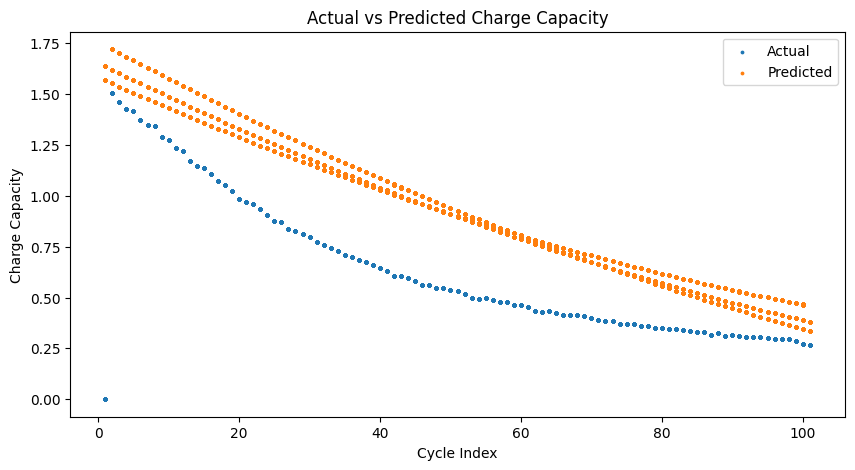

In [49]:
# Using polynomial regression
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Polynomial Degree:", degree)
print("MSE:", mse)
print("R2 Score:", r2)

# show coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

plt.figure(figsize=(10,5))
plt.scatter(test["Cycle_Index"], y_test, label="Actual", s=3)
plt.scatter(test["Cycle_Index"], y_pred, label="Predicted", s=3)
plt.xlabel("Cycle Index")
plt.ylabel("Charge Capacity")
plt.title("Actual vs Predicted Charge Capacity")
plt.legend()
plt.show()

MSE: 0.09982158443600822
R2 Score: 0.31351298210005507


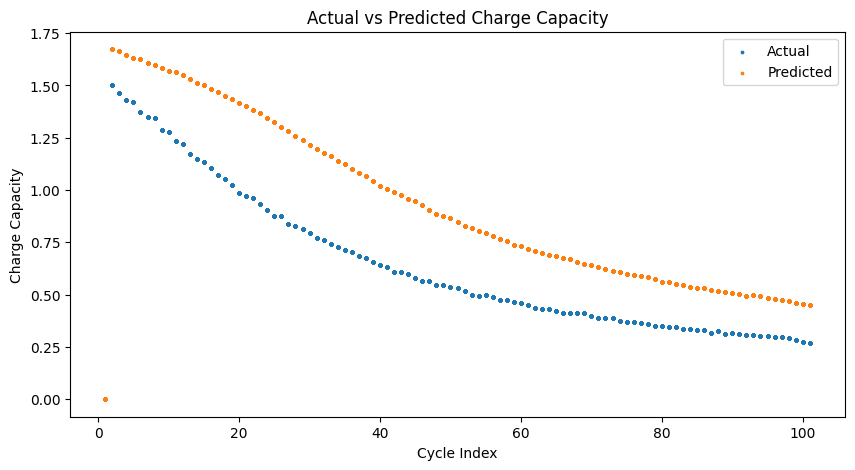

In [50]:
# Using Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators= 300,         # number of trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 Score:", r2)

plt.figure(figsize=(10,5))
plt.scatter(test["Cycle_Index"], y_test, label="Actual", s=3)
plt.scatter(test["Cycle_Index"], y_pred, label="Predicted", s=3)
plt.xlabel("Cycle Index")
plt.ylabel("Charge Capacity")
plt.title("Actual vs Predicted Charge Capacity")
plt.legend()
plt.show()

> ## Observation
- Polynomial Regression of degree=2 could not capture the trend of charge capacity very well and gave a R2 score of just 11%.
- Random Forest Regressor did show some off-set from the true values, but was able to capture the outliers and the trend very well and gave a R2 score of 31%, which is a lot better than Polynomial Regression and can also be imporved further.

#### Discharge Capacity

In [13]:
# Filter valid values
data = final_df.dropna(subset=["discharge_capacity"])

# Split into train (first 101 cycles) and test (remaining)
train = data[data["Cycle_Index"] <= 101]
test = data[data["Cycle_Index"] > 101]
test["Cycle_Index"] = test["Cycle_Index"] - 101

X_train = train[["Cycle_Index", "c_rate"]]
y_train = train["discharge_capacity"]

X_test = test[["Cycle_Index", "c_rate"]]
y_test = test["discharge_capacity"]

Polynomial Degree: 2
MSE: 0.1075736221930522
R2 Score: 0.37812852608480785
Model Coefficients: [ 0.00000000e+00 -2.32090126e-02 -7.06094764e-03  9.15577859e-05
  1.00164500e-04  1.32636116e-03]
Model Intercept: 1.8054992127595684


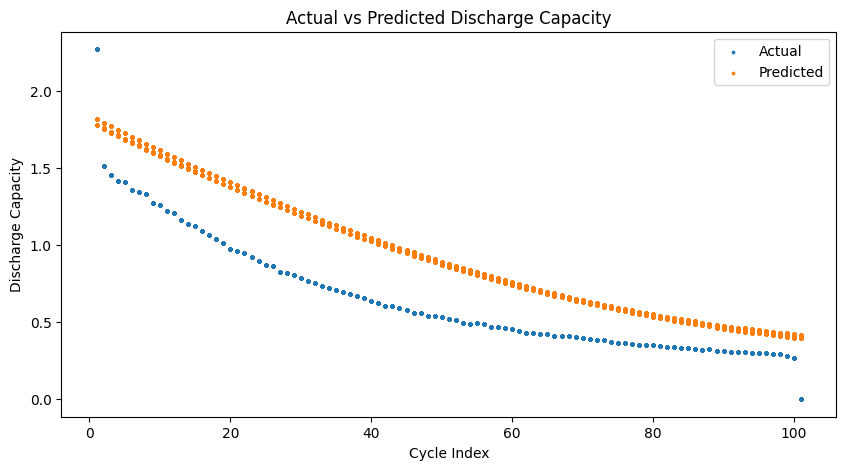

In [14]:
# Using polynomial regression
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Polynomial Degree:", degree)
print("MSE:", mse)
print("R2 Score:", r2)

# show coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

plt.figure(figsize=(10,5))
plt.scatter(test["Cycle_Index"], y_test, label="Actual", s=3)
plt.scatter(test["Cycle_Index"], y_pred, label="Predicted", s=3)
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity")
plt.title("Actual vs Predicted Discharge Capacity")
plt.legend()
plt.show()

MSE: 0.09920996440920381
R2 Score: 0.4264779270562664


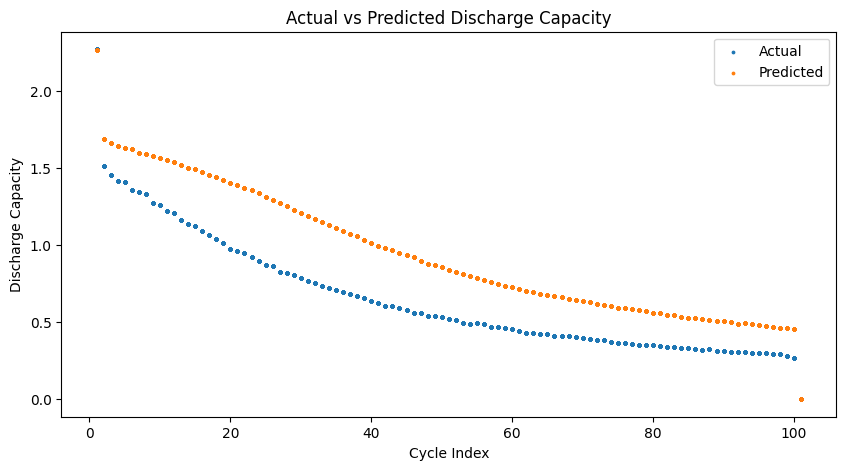

In [15]:
# Using Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators= 300,         # number of trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 Score:", r2)

plt.figure(figsize=(10,5))
plt.scatter(test["Cycle_Index"], y_test, label="Actual", s=3)
plt.scatter(test["Cycle_Index"], y_pred, label="Predicted", s=3)
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity")
plt.title("Actual vs Predicted Discharge Capacity")
plt.legend()
plt.show()

> ## Observation
- Here also, Polynomial Regression showed somewhat linear trend and could not capture the outliers and gave a R2 Score of 37%.
- On the other hand, Random Forest Regressor was able to capture the trend and the outliers very well with a R2 score of 42% but also showed some off-set in true and predicted values and can also be improved further with more data and hyperparameter tuning.

#### SoH

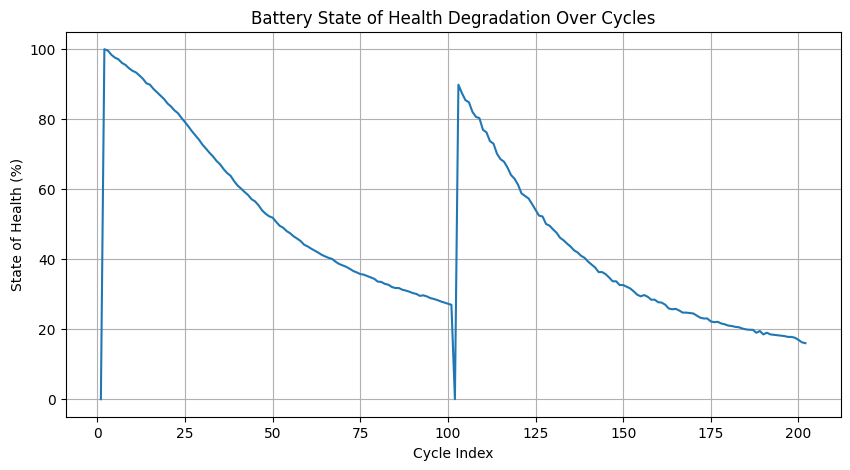

In [16]:
# Using rated capacity (2.3 Ah)
rated_capacity = 2.3
df = final_df.copy()
final_df["SoH_rated"] = (final_df["charge_capacity"] / rated_capacity) * 100

# Using initial cycle measured capacity
initial_capacity = final_df.loc[final_df["Cycle_Index"] == 2, "charge_capacity"].mean()
final_df["SoH_measured"] = (final_df["charge_capacity"] / initial_capacity) * 100

cycle_soh = final_df.groupby("Cycle_Index")["SoH_measured"].mean()

plt.figure(figsize=(10,5))
plt.plot(cycle_soh.index, cycle_soh.values)
plt.xlabel("Cycle Index")
plt.ylabel("State of Health (%)")
plt.title("Battery State of Health Degradation Over Cycles")
plt.grid(True)
plt.show()


In [51]:
cycle_soh.head(10)

Cycle_Index
1       0.000000
2     100.000000
3      99.601314
4      98.401423
5      97.600598
6      97.123779
7      96.088223
8      95.526232
9      94.570568
10     93.853439
Name: SoH_measured, dtype: float64

> ## Observation
- From the graph, it is interpreted the battery health goes down over time. At the beginning, it drops very fast, then it slowly keeps going lower.
- In the second ha, depicts data from some another battery or after resetting cycle count and this time the health degrades at a faster rate. It shows the battery becomes weaker and weaker the more it is used.